# **Movie Recommender**
# Group 10
# Blake Burns, Christian Coulter, Alexander Pegg

**Import Libraries**

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from scipy.sparse import csr_matrix
from sklearn.neighbors import NearestNeighbors
from sklearn.model_selection import train_test_split
from math import pow, sqrt
import os

**Load Dataset**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:
!cp /content/drive/My\ Drive/FINAL_PROJECT/* ./
!ls

credits.csv   links.csv        movies_metadata.csv  sample_data
drive	      links_small.csv  ratings.csv
keywords.csv  movies.csv       ratings_small.csv


In [ ]:
movies = pd.read_csv('movies.csv')
ratings = pd.read_csv('ratings.csv')

**Understand Data**


*Movies Dataset*

In [ ]:
print(movies.head())
print(movies.shape)

   movieId  ...                                       genres
0        1  ...  Adventure|Animation|Children|Comedy|Fantasy
1        2  ...                   Adventure|Children|Fantasy
2        3  ...                               Comedy|Romance
3        4  ...                         Comedy|Drama|Romance
4        5  ...                                       Comedy

[5 rows x 3 columns]
(10329, 3)


In [ ]:
print(movies.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10329 entries, 0 to 10328
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   movieId  10329 non-null  int64 
 1   title    10329 non-null  object
 2   genres   10329 non-null  object
dtypes: int64(1), object(2)
memory usage: 242.2+ KB
None


*Ratings Dataset*

In [ ]:
print(ratings.head())
print(ratings.shape)

   userId  movieId  rating   timestamp
0       1       16     4.0  1217897793
1       1       24     1.5  1217895807
2       1       32     4.0  1217896246
3       1       47     4.0  1217896556
4       1       50     4.0  1217896523
(105339, 4)


In [ ]:
print(ratings.info())
print(ratings.columns)
print(ratings.rating.value_counts)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 105339 entries, 0 to 105338
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   userId     105339 non-null  int64  
 1   movieId    105339 non-null  int64  
 2   rating     105339 non-null  float64
 3   timestamp  105339 non-null  int64  
dtypes: float64(1), int64(3)
memory usage: 3.2 MB
None
Index(['userId', 'movieId', 'rating', 'timestamp'], dtype='object')
<bound method IndexOpsMixin.value_counts of 0         4.0
1         1.5
2         4.0
3         4.0
4         4.0
         ... 
105334    4.0
105335    3.5
105336    4.0
105337    2.5
105338    4.5
Name: rating, Length: 105339, dtype: float64>


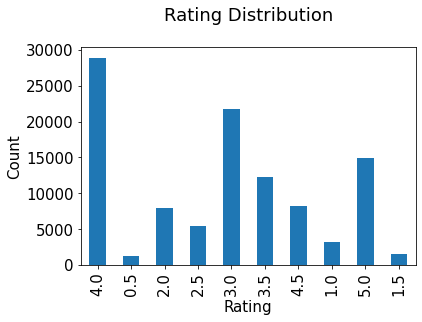

In [ ]:
plt.rc("font", size=15)
ratings.rating.value_counts(sort=False).plot(kind='bar')
plt.title('Rating Distribution\n')
plt.xlabel('Rating')
plt.ylabel('Count')
plt.show()

**Merge Datasets**

In [ ]:
avg_ratings = ratings.groupby(['movieId'],as_index=False)['rating'].mean()
avg_ratings.head()

,movieId,rating
0,1,3.907328
1,2,3.353261
2,3,3.189655
3,4,2.818182
4,5,3.250000


In [ ]:
movies2 = pd.merge(movies, ratings, on='movieId')
movies2.round(1)

,movieId,title,genres,userId,rating,timestamp
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,2,5.0,859046895
1,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,5,4.0,1303501039
2,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,8,5.0,858610933
3,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,11,4.0,850815810
4,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,14,4.0,851766286
...,...,...,...,...,...,...
105334,148238,A Very Murray Christmas (2015),Comedy,475,3.0,1451213043
105335,148626,The Big Short (2015),Drama,458,4.0,1452014749
105336,148626,The Big Short (2015),Drama,576,4.5,1451687664
105337,148626,The Big Short (2015),Drama,668,4.5,1451148148


In [ ]:
# Separting movie title and year part using split function
split_values = movies2['title'].str.split("(", n = 1, expand = True) 

# setting 'movie_title' values to title part and creating 'release_year' column.
movies2.title = split_values[0]
movies2['release_year'] = split_values[1]

# Cleaning the release_year series and dropping 'genre' columns as it has already been one hot encoded.
movies2['release_year'] = movies2.release_year.str.replace(')','')


In [ ]:
movies2.head()

,movieId,title,genres,userId,rating,timestamp,release_year
0,1,Toy Story,Adventure|Animation|Children|Comedy|Fantasy,2,5.0,859046895,1995
1,1,Toy Story,Adventure|Animation|Children|Comedy|Fantasy,5,4.0,1303501039,1995
2,1,Toy Story,Adventure|Animation|Children|Comedy|Fantasy,8,5.0,858610933,1995
3,1,Toy Story,Adventure|Animation|Children|Comedy|Fantasy,11,4.0,850815810,1995
4,1,Toy Story,Adventure|Animation|Children|Comedy|Fantasy,14,4.0,851766286,1995


**Create kNN Model**

In [ ]:

movies2 = movies2.drop_duplicates(['userId', 'title'])
movies_piv = movies2.pivot(
    index='title',
    columns='userId',
    values='rating'
).fillna(0)

movies_matrix = csr_matrix(movies_piv.values)

In [ ]:
movies_piv.head()

userId,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,...,629,630,631,632,633,634,635,636,637,638,639,640,641,642,643,644,645,646,647,648,649,650,651,652,653,654,655,656,657,658,659,660,661,662,663,664,665,666,667,668
title,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.5,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0
'71,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
'Hellboy': The Seeds of Creation,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
'Round Midnight,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.5
'Til There Was You,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
movies_piv_binary = movies_piv.apply(np.sign)
movies_piv_binary_matrix = csr_matrix(movies_piv_binary.values)

In [ ]:
model = NearestNeighbors(metric='cosine', algorithm='brute', n_neighbors = 10)

model.fit(movies_matrix)


NearestNeighbors(algorithm='brute', leaf_size=30, metric='cosine',
                 metric_params=None, n_jobs=None, n_neighbors=10, p=2,
                 radius=1.0)

In [ ]:
print(movies_matrix.indices)

[ 19  37  62 ... 626 667 667]


In [ ]:
import string
!pip install fuzzywuzzy
from fuzzywuzzy import fuzz
from sklearn.metrics.pairwise import cosine_similarity

#indices needs to be a list of names of the top movies by name with the query movie at the beginning
def avg_cosine_similarity(indices, matrix):  
  rec_movies = matrix.loc[indices]
  similarity = np.mean(cosine_similarity(rec_movies, rec_movies)[0][1:])
  return similarity

def print_recommendations(query_title, movie_matrix, knn_model, k, prnt=1):
    query_index = None
    ratio_tuples = []
    
    for i in movie_matrix.index:
        ratio = fuzz.ratio(i.lower(), query_title.lower())
        if ratio >= 75:
            current_query_index = movie_matrix.index.tolist().index(i)
            ratio_tuples.append((i, ratio, current_query_index))
    
    #print('Possible matches: {0}\n'.format([(x[0], x[1]) for x in ratio_tuples]))
    
    try:
        query_index = max(ratio_tuples, key = lambda x: x[1])[2] # get the index of the best artist match in the data
    except:
        print('Your title didn\'t match any in the data. Try again')
        return None
    
    distances, indices = knn_model.kneighbors(movie_matrix.iloc[query_index, :].values.reshape(1, -1), n_neighbors = k + 1)
    top_movies = []
    for i in indices.flatten():
      top_movies.append(movie_matrix.index[i])
    similarity = avg_cosine_similarity(top_movies, movie_matrix)

    if prnt == 1:
      for i in range(0, len(distances.flatten())):
        if i == 0:
          print('Recommendations for {0}:\n'.format(movie_matrix.index[query_index]))
        else:
          print('{0}: {1}(distance: {2})'.format(i, movie_matrix.index[indices.flatten()[i]], distances.flatten()[i]))

      print('\nAverage cosine similarity: {0}'.format(similarity))
    
    return similarity


/usr/local/lib/python3.6/dist-packages/fuzzywuzzy/fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')


Run cell below for KNN recommendations

In [ ]:
recommendation = input('Enter a movie title for recommendations: ')
avgcossimilarity = print_recommendations(recommendation, movies_piv_binary, model, k=10)

Enter a movie title for recommendations: thor
Recommendations for Thor :

1: Iron Man 3 (distance: 0.3431007237569832)
2: Men in Black III (distance: 0.3589941135357907)
3: Iron Man 2 (distance: 0.43299411950968825)
4: Captain America: The First Avenger (distance: 0.43693210485283873)
5: X-Men: First Class (distance: 0.43879627195940263)
6: Captain America: The Winter Soldier (distance: 0.44430721940701623)
7: Avengers, The (distance: 0.4642197006447156)
8: Amazing Spider-Man, The (distance: 0.4683878924549958)
9: Daybreakers (distance: 0.4703141126264213)
10: Green Lantern (distance: 0.4728633286083196)

Average cosine similarity: 0.5602630422266682


**Truncated SVD**

In [ ]:
movies_piv2 = movies2.pivot(index = 'userId', columns = 'title', values = 'rating').fillna(0)
movies_piv2.head()

title,,'71,'Hellboy': The Seeds of Creation,'Round Midnight,'Til There Was You,"'burbs, The",'night Mother,*batteries not included,...And Justice for All,10,10 Items or Less,10 Things I Hate About You,10 to Midnight,"10,000 BC",100 Girls,101 Dalmatians,101 Reykjavik,102 Dalmatians,10th & Wolf,"10th Kingdom, The",11-11-11,11:14,"11th Hour, The",12,12 Angry Men,12 Rounds,12 Years a Slave,127 Hours,12:01,13,13 Assassins,13 Ghosts,13 Going on 30,13 Rue Madeleine,"13th Warrior, The",1408,1492: Conquest of Paradise,15 Minutes,16 Blocks,17 Again,...,Yves Saint Laurent,Z,Zabriskie Point,Zach Galifianakis: Live at the Purple Onion,Zack and Miri Make a Porno,Zandalee,Zapped!,Zardoz,Zathura,Zatoichi and the Chest of Gold,Zebraman,Zeitgeist: Addendum,Zeitgeist: Moving Forward,Zeitgeist: The Movie,Zelary,Zelig,Zero Dark Thirty,Zero Day,Zero Effect,Zodiac,Zombie Strippers!,Zombieland,Zone 39,Zookeeper,Zoolander,Zorba the Greek,"Zorro, the Gay Blade",Zozo,Zu: Warriors from the Magic Mountain,Zulu,[REC],[REC]²,[REC]³ 3 Génesis,a/k/a Tommy Chong,eXistenZ,loudQUIETloud: A Film About the Pixies,xXx,xXx: State of the Union,¡Three Amigos!,À nous la liberté
userId,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
movies_piv2.shape

(668, 9944)

In [ ]:
X = movies_piv2.values.T
X.shape

(9944, 668)

In [ ]:
import sklearn

from sklearn.decomposition import TruncatedSVD

SVD = TruncatedSVD(n_components = 12, random_state=17)
matrix = SVD.fit_transform(X)
matrix.shape
print(matrix)

[[ 8.02671069e+00  8.97229690e+00  1.11744744e+00 ...  2.85877365e+00
   2.32267985e+00  1.82367066e+00]
 [ 6.53206200e-01  5.61282615e-02 -8.83080281e-01 ...  2.75547609e-01
  -8.07530480e-01  1.08805092e+00]
 [ 9.25074802e-03 -1.12818423e-03  1.46581910e-03 ...  8.41829718e-03
   1.25139592e-02  5.01207289e-03]
 ...
 [ 1.45241182e+00  2.08828333e+00  2.04786636e-01 ...  7.48205206e-01
  -5.89338435e-01 -3.60110746e-01]
 [ 8.31390486e+00 -1.33066851e+00 -1.25432888e+00 ...  4.84146558e-01
  -6.37383220e-02  4.11180950e-01]
 [ 6.62371994e-01  6.45399111e-01 -2.04415895e+00 ... -4.58333513e-01
  -1.66202161e-01 -1.02673781e-01]]


In [ ]:
import warnings
warnings.filterwarnings("ignore", category = RuntimeWarning)
corr = np.corrcoef(matrix)
corr.shape
print(corr)

[[ 1.          0.42671069 -0.05226282 ...  0.68329819  0.24766994
   0.01583432]
 [ 0.42671069  1.          0.070199   ...  0.2165272   0.39296102
   0.05040337]
 [-0.05226282  0.070199    1.         ...  0.27791677  0.48664544
  -0.16546827]
 ...
 [ 0.68329819  0.2165272   0.27791677 ...  1.          0.1550645
  -0.02875013]
 [ 0.24766994  0.39296102  0.48664544 ...  0.1550645   1.
   0.09636135]
 [ 0.01583432  0.05040337 -0.16546827 ... -0.02875013  0.09636135
   1.        ]]


In [ ]:
movies_title = movies_piv2.columns
movies_list = list(movies_title)
movies_list[1]

"'71 "

In [ ]:
recommendation = input('Enter a movie title for recommendations: ')
movie_to_use = movies_list.index(recommendation + ' ')

ts = corr[movie_to_use]

top_movies = np.array(movies_title[(ts < 1.0) & (ts>0.90)])

print(*top_movies, sep = '\n')

avgcossimilarity = avg_cosine_similarity(np.insert(top_movies, 0, movies_piv_binary.index[movie_to_use]), movies_piv_binary)
print(avgcossimilarity)

Enter a movie title for recommendations: Thor
Avengers, The 
Captain America: The First Avenger 
Chappie 
Dark Knight Rises, The 
Despicable Me 
Dredd 
Hellboy II: The Golden Army 
Iron Man 2 
Iron Man 3 
Machete 
Maze Runner, The 
Megamind 
National Treasure 
Neighbors 
Pirates of the Caribbean: At World's End 
Scott Pilgrim vs. the World 
Sherlock Holmes 
Song of the Sea 
Way of the Dragon, The 
Who Am I? 
Wreck-It Ralph 
Zombieland 


In [ ]:
#if we wanted to get the top x movies:
#query_title is the index of the movie, not the title
def print_recommendationsSVD(query_title, movie_matrix, num_recommendations, prnt=1):
  ts = corr[query_title]
  indices = np.expand_dims(range(len(ts)), axis=0)
  sorted_ts = np.concatenate([indices, np.expand_dims(ts, axis=0)])
  sorted_ts = sorted_ts[:, sorted_ts[1].argsort()]
  topx = sorted_ts[0, -(num_recommendations + 1):] #take top x + 1, top movie is queried movie
  top_movies = []
  for i in topx.flatten():
    top_movies.append(movies_title[i])
  top_movies = top_movies[::-1]

  similarity = avg_cosine_similarity(top_movies, movie_matrix)

  if prnt == 1:
    print(*top_movies[1:], sep = '\n')
    print('\nAverage cosine similarity: {0}'.format(similarity))

  return similarity

Run cell below for SVD recommendations

In [ ]:
recommendation = input('Enter a movie title for recommendations: ')
movie_to_use = movies_list.index(recommendation + ' ')
avgcossimilarity = print_recommendationsSVD(movie_to_use, movies_piv_binary, num_recommendations=10)

Enter a movie title for recommendations: Thor
Iron Man 3 
Megamind 
Scott Pilgrim vs. the World 
Iron Man 2 
Who Am I? 
Despicable Me 
Chappie 
Wreck-It Ralph 
Avengers, The 
Dredd 

Average cosine similarity: 0.447648765468142


Run cell below to test both algorithms with a random sample of titles. Adjust the sample_size variable to adjust the amount of movies run through each algorithm.

In [ ]:
sample_size = 100
titles = np.random.choice(movies_title, sample_size)
#print(titles)
similaritySVD = []
similarityKNN = []
for i in titles:
  similaritySVD.append(print_recommendationsSVD(movies_list.index(i), movies_piv_binary, num_recommendations=10, prnt=0))
  similarityKNN.append(print_recommendations(i, movies_piv_binary, model, k=10, prnt=0))
print('Mean average cosine similarity for KNN: {0}'.format(np.mean(similarityKNN)))
print('Mean average cosine similarity for SVD: {0}'.format(np.mean(similaritySVD)))

Mean average cosine similarity for KNN: 0.7301887938091811
Mean average cosine similarity for SVD: 0.6222718971633783


**VISUALIZATION**

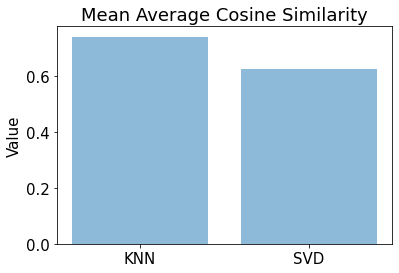

In [ ]:
objects = ('KNN', 'SVD')
y_pos = np.arange(len(objects))

performance = [np.mean(similarityKNN), np.mean(similaritySVD)]

plt.bar(y_pos, performance, align='center', alpha=0.5)
plt.xticks(y_pos, objects)
plt.ylabel('Value')
plt.title('Mean Average Cosine Similarity')

plt.show()

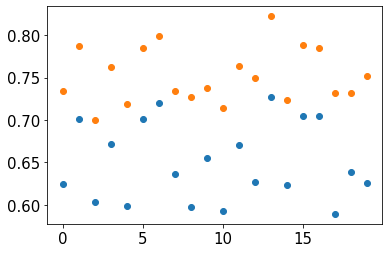

In [ ]:
xaxis = range(20)
svdresults = []
knnresults = []
for j in xaxis:
  sample_size = 50
  titles = np.random.choice(movies_title, sample_size)
  similaritySVD = []
  similarityKNN = []
  for i in titles:
    similaritySVD.append(print_recommendationsSVD(movies_list.index(i), movies_piv_binary, num_recommendations=10, prnt=0))
    similarityKNN.append(print_recommendations(i, movies_piv_binary, model, k=10, prnt=0))
  svdresults.append(np.mean(similaritySVD))
  knnresults.append(np.mean(similarityKNN))
plt.scatter(xaxis, svdresults)
plt.scatter(xaxis, knnresults)
plt.show()

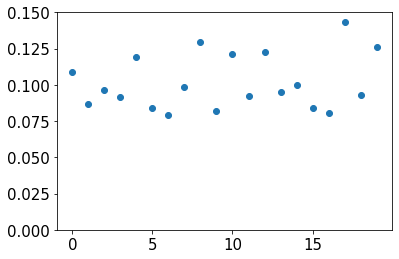

In [ ]:
diff = []
for i in range(len(knnresults)):
  diff.append(knnresults[i] - svdresults[i])
plt.scatter(xaxis, diff)
plt.gca().set_ylim([0, .15])
plt.show()